# Part 1

## Components

In [1]:
from langchain_ollama import ChatOllama

model = ChatOllama(
    model = "qwen3",
    temperture = 0
)

In [2]:
from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(model = "nomic-embed-text")

In [3]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

## Indexing

#### Loading Documents

In [6]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43047


In [7]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


#### Splitting Documnets

In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


#### Storing Documents

In [11]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['4a60532e-c5f9-4d54-bb70-f5cc350a2a3a', '33c9ecfd-40d6-4868-b77a-d5be3d2b63db', 'c170a67d-6939-4372-b192-f6c63921353c']


## Retrieval and Generation

In [14]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

C:\Users\ASUS\miniconda3\envs\Ollama\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [15]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [16]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}

In [17]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

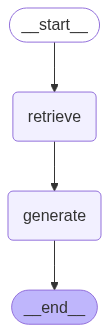

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='c170a67d-6939-4372-b192-f6c63921353c', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1638}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth

In [21]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='c170a67d-6939-4372-b192-f6c63921353c', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1638}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can

In [22]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

<think>|
|Okay|,| the| user| is| asking| about| Task| Decom|position|.| Let| me| look| through| the| provided| context| to| find| the| answer|.

|The| context| mentions| that| Task| Decom|position| is| a| method| to| break| down| complex| tasks| into| smaller|,| manageable| steps|.| It| references| Chain| of| Thought| (|Co|T|)| and| Tree| of| Thoughts| as| techniques| where| models| think| step| by| step| or| explore| multiple| reasoning| paths|.| Also|,| there| are| methods| like| using| L|LM| prompts|,| task|-specific| instructions|,| and| even| external| planners| like| L|LM|+|P|.| 

|I| need| to| summarize| this| in| three| sentences|.| First|,| define| Task| Decom|position|.| Then| mention| the| main| techniques| like| Co|T| and| Tree| of| Thoughts|.| Finally|,| note| other| approaches| like| prompting| and| external| planners|.| Make| sure| it|'s| concise| and| within| the| limit|.
|</think>|

|Task| decomposition| is| a| method| to| break| down| complex| tasks| into| smaller|,| 

In [23]:
# result = await graph.ainvoke(...)

# async for step in graph.astream(...):

In [24]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

## Query Analysis

In [25]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

In [26]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

In [27]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

In [31]:
class State(TypedDict):
    question: str
    query: Search ########################################################################
    context: List[Document]
    answer: str


def analyze_query(state: State): #########################################################
    structured_llm = model.with_structured_output(Search) ################################
    query = structured_llm.invoke(state["question"]) #####################################
    return {"query": query} ##############################################################


def retrieve(state: State):
    query = state["query"] ###############################################################
    retrieved_docs = vector_store.similarity_search( #####################################
        query["query"], ##################################################################
        filter=lambda doc: doc.metadata.get("section") == query["section"], ##############
    ) ####################################################################################
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate]) ######
graph_builder.add_edge(START, "analyze_query") ###########################################
graph = graph_builder.compile()

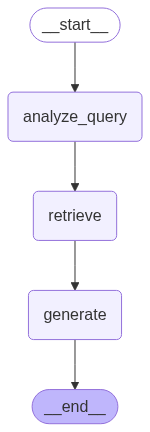

In [32]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'What does the end of the post say about Task Decomposition?', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='179fffc6-c818-48fb-8c8f-1a0e7963fd5b', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 32858, 'section': 'end'}, page_content='}\n]\nThen after these clarification, the agent moved into the code writing mode with a different system message.\nSystem message:'), Document(id='ef26690a-a078-434a-b1ef-da098aca2653', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 30868, 'section': 'end'}, page_content='Here are a sample conversation for task clarification sent to OpenAI ChatCompletion endpoint used by GPT-Engineer. The user inputs are wrapped in {{user input text}}.\n[\n  {\n    "role": "system",\n    "content": "You will read instructions and not carry them out, only seek to clarify them.\\nSpecifically you will first summarise a